In [2]:
%%R
# load coloc and dependencies
suppressPackageStartupMessages(suppressWarnings({
    library(gwasglue)
    library(dplyr)
    library(gassocplot)
    library(coloc)
    library(ggplot2)
}))
# additional packages for handling parquet files
library(arrow)
library(duckdb)
library(fs)
library(tidyverse)
library(DBI)
library(glue)
library(tictoc)

API: public: http://gwas-api.mrcieu.ac.uk/



In [6]:
%%bash
# convert eQTL-Gen whole blood cis-eqtl and MAF flatfiles to parquet format



7.754 sec elapsed


ERROR: Error: Invalid: CSV parse error: Row #19787051: Expected 6 columns, got 11: 0.01058831	rs916930	7	117417065	2.5561	2


: 

In [10]:
# dir_eqtl <- "eqtls"
dir_eqtlmaf <- "eqtl_MAF"

# open parquet files
# ds_eQTL <- arrow::open_dataset(dir_eqtl, partitioning = "SNPChr")
ds_eqtlMAF <- arrow::open_dataset(dir_eqtlmaf, partitioning = "hg19_chr")

con <- dbConnect(duckdb::duckdb())

# register the dataset as a DuckDB table, and give it a name
# duckdb::duckdb_register_arrow(con, "eqtlTable", ds_eQTL)
duckdb::duckdb_register_arrow(con, "mafTable", ds_eqtlMAF)

# read in the file
# query the table for each chromosome separately
for (chr in 1:22) {
    
    # Left join result and 2018-07-18_SNP_AF_for_AlleleB_combined_allele_counts_and_MAF_pos_added.txt  on SNPChr and SNPPos
    query <- glue::glue(
        "
        SELECT SNP, hg19_pos
        FROM 'eqtl_MAF/hg19_chr={chr}/*.parquet'
        "
    )
    tic()
    result <- dbGetQuery(con, query)
    toc()
    # and print the first 10 rows
    print(head(result, 10))
}
# clean up
duckdb_unregister(con, "eqtlTable")
duckdb_unregister(con, "mafTable")
dbDisconnect(con)

2.344 sec elapsed
           SNP hg19_pos
1  rs148108408  8289857
2     rs385504  8289919
3     rs438650  8290082
4   rs79309487  8290150
5     rs534231  8290279
6   rs11121138  8290743
7   rs12022853  8290762
8  rs113115115  8290848
9   rs12064128  8291304
10  rs72635739  8291343
2.247 sec elapsed
           SNP hg19_pos
1  rs193294418    10345
2  rs185496709    10386
3  rs184397180    10431
4  rs181082102    10481
5   rs28804817    10587
6   rs28880666    10596
7  rs145525592    10610
8  rs114772193    10649
9  rs115970550    10682
10  rs28888107    10797
1.839 sec elapsed
           SNP hg19_pos
1  rs115479960    60197
2  rs141398405    60363
3  rs186088964    60383
4   rs13067307    60596
5  rs138886950    60648
6  rs183071864    60795
7   rs75519952    60799
8    rs9755941    61044
9    rs9756992    61113
10 rs192401132    61365
1.671 sec elapsed
           SNP hg19_pos
1  rs114682541    10240
2  rs117029972    11870
3  rs114122860    11961
4  rs141742467    14306
5    rs6825667  

: 

In [4]:
# wbc count related to autoimmune disease
gwas_dataset <- "ieu-b-30"
dummy_dataset <- "ieu-a-7"
gwasinfo(id = as.character(gwas_dataset))
# gwasinfo(id=as.character(dummy_dataset))


ERROR: Error in gwasinfo(id = as.character(gwas_dataset)): could not find function "gwasinfo"


In [17]:
# queries API from https://gwas.mrcieu.ac.uk/ to:
    # 1) grab VCF file and 
    # 2) identify top GWAS hits
    # 3) sort by p-value order (lowest to highest)
top <- ieugwasr::tophits("ieu-b-30") %>% arrange(p)
print(paste0(dim(top)[1], " GWAS hits identified"))
head(top)


[1] "509 GWAS hits identified"


chr,position,beta,se,p,n,id,rsid,ea,nea,eaf,trait
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
6,31236115,0.077234,0.001878,0.00000e+00,561159,ieu-b-30,rs2853951,T,C,0.599507,white blood cell count
17,38089344,0.072120,0.001861,0.00000e+00,561295,ieu-b-30,rs4794820,G,A,0.552137,white blood cell count
12,111884608,-0.067191,0.001836,3.68978e-293,559426,ieu-b-30,rs3184504,C,T,0.517084,white blood cell count
4,74948054,-0.063244,0.001899,3.49945e-243,562241,ieu-b-30,rs1371794,C,A,0.622486,white blood cell count
7,28724374,0.059326,0.002043,2.72898e-185,561153,ieu-b-30,rs56388170,T,G,0.294509,white blood cell count
19,44153100,-0.070234,0.002594,2.20800e-161,560511,ieu-b-30,rs4760,G,A,0.152719,white blood cell count


In [ ]:
window_size <- 50000
if (!dir.exists("gwas_hits")) {
    dir.create("gwas_hits")
}

# parallel loop over the top GWAS hits in p-value order and iterate over rows
foreach(i = 1:nrow(top)) %dopar% {
    # str(top[i,])
    # add leading 0s to pval_rank_gwashit so that it always has 3 digits
    pval_rank_gwashit <- sprintf("%03d", i)
    chr_gwashit <- top[i, ]$chr
    pos_gwashit <- top[i, ]$position

    # print(paste0("Processing GWAS hit ", pval_rank_gwashit, " of ", nrow(top)))

    lower <- pos_gwashit - window_size
    upper <- pos_gwashit + window_size
    # print(paste(pval_rank_gwashit," ",chr_gwashit," ",lower," ",upper))
    chrpos <- paste0(chr_gwashit, ":", lower, "-", upper)
    # print(chrpos)

    # extract SNPS in the region of top hit
    out <- ieugwasr_to_coloc(
        id1 = as.character(gwas_dataset),
        id2 = as.character(dummy_dataset),
        chrompos = as.character(chrpos),
        type1 = "quant",
        # type2 = "cc"
    )

    # get rid of dummy dataset
    out <- out[1]$dataset1
    # str(out)

    # export to file (tab-delimited) in directory named gwas_hits in the following format:
    # <pval rank>_<chr>_<lower bound>_<upper bound>.tsv
    write.table(out,
        file = paste0(
            "gwas_hits/", pval_rank_gwashit, "_", chr_gwashit, "_", lower, "_", upper, "_gwas.tsv"
        ),
        sep = "\t", quote = FALSE, row.names = FALSE, col.names = TRUE
    )
}


In [ ]:
# Build eQTL DB
# python3 eQTL_build_db.py

# Query eQTL DB; Change integer in "-P0" to specify the number of threads
# find gwas_hits/ -type f -name "*" | \
# xargs -P0 -I{} python3 eQTL_query_db.py --input_file {} --db_name eQTLs.db --output_dir eqtl_hits
    # can check gnomad if maf assumptions are reasonable

In [ ]:
# gather up all the gwas and eqtl files
gwas_file_list <- list.files(path = "gwas_hits", pattern = ".tsv", full.names = TRUE)
eqtl_file_list <- list.files(path = "output_full", pattern = ".tsv", full.names = TRUE)

# str(gwas_file_list)
# str(eqtl_file_list)

# make a directory named output_coloc if it doesn't exist
dir.exists("output_coloc") || dir.create("output_coloc")

for (i in seq_along(gwas_file_list)) {

    # loop over elements in gwas_file_list and eqtl_file_list at the same time
    gwas_file <- gwas_file_list[i]
    eqtl_file <- eqtl_file_list[i]

    gwas_data <- as.list(read.table(file = gwas_file, header = TRUE, sep = "\t"))

    # working around formatting issues
    eqtl_data <- read.table(file = eqtl_file, header = FALSE, sep = "\t", fill = TRUE)
    # drop the last column in eqtl_data - not sure why there is an empty column read in from the file???
    eqtl_data <- eqtl_data[, -ncol(eqtl_data)]
    # rename the columns by first element
    colnames(eqtl_data) <- eqtl_data[1, ]
    # drop the first row
    eqtl_data <- eqtl_data[-1, ]
    # set column data types manually
    eqtl_data$pvalues <- as.numeric(eqtl_data$pvalues)
    eqtl_data$N <- as.integer(eqtl_data$N)
    eqtl_data$MAF <- as.numeric(eqtl_data$MAF)
    eqtl_data$beta <- as.numeric(eqtl_data$beta)
    eqtl_data$varbeta <- as.numeric(eqtl_data$varbeta)
    eqtl_data$type <- as.character(eqtl_data$type)
    eqtl_data$snp <- as.character(eqtl_data$snp)
    eqtl_data$z <- as.numeric(eqtl_data$z)
    eqtl_data$chr <- as.integer(eqtl_data$chr)
    eqtl_data$pos <- as.integer(eqtl_data$pos)
    eqtl_data$id <- as.character(eqtl_data$id)

    eqtl_data <- as.list(eqtl_data)

    # run coloc
    res <- coloc::coloc.abf(gwas_data, eqtl_data)

    #  Get locus from filenames
    SNP_locus_name <- basename(gwas_file)
    SNP_locus_name <- sub("_gwas\\..*$", "", SNP_locus_name)
    # split on _ assign first element to pval_rank, second to chr, third to lower bound, fourth to upper bound
    SNP_locus_name <- strsplit(SNP_locus_name, "_")
    # flatten to vector
    SNP_locus_name <- unlist(SNP_locus_name)
    pval_rank <- SNP_locus_name[1]
    chr <- SNP_locus_name[2]
    lower <- SNP_locus_name[3]
    upper <- SNP_locus_name[4]


    # write posterior probability output to separate log files
    # if H4 >= 80%, send to one file
    if (as.numeric(res$summary["PP.H4.abf"]) >= 0.8) {
        write.table(paste(pval_rank, chr, lower, upper, as.numeric(res$summary["PP.H1.abf"]), as.numeric(res$summary["PP.H2.abf"]), as.numeric(res$summary["PP.H3.abf"]), as.numeric(res$summary["PP.H4.abf"])),
            file = paste0(
                "output_coloc/H4gt80.tsv"
            ),
            sep = "\t", quote = FALSE, row.names = FALSE, col.names = FALSE, append = TRUE
        )
        # if H4 < 80%, send to another file
    } else if (as.numeric(res$summary["PP.H4.abf"]) < 0.8) {
        write.table(paste(pval_rank, chr, lower, upper, as.numeric(res$summary["PP.H1.abf"]), as.numeric(res$summary["PP.H2.abf"]), as.numeric(res$summary["PP.H3.abf"]), as.numeric(res$summary["PP.H4.abf"])),
            file = paste0(
                "output_coloc/H4lt80.tsv"
            ),
            sep = "\t", quote = FALSE, row.names = FALSE, col.names = FALSE, append = TRUE
        )
    }
    # write.table(paste(pval_rank,chr,lower,upper,as.numeric(res$summary["PP.H1.abf"]),as.numeric(res$summary["PP.H2.abf"]),as.numeric(res$summary["PP.H3.abf"]),as.numeric(res$summary["PP.H4.abf"])), file = paste0("output_coloc/", "posteriors.tsv"), sep = "\t", quote=FALSE, row.names = FALSE, col.names = FALSE, append = TRUE)
}


,pval_rank,chr,lower,upper,PP.H1.abf,PP.H2.abf,PP.H3.abf,PP.H4.abf
,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
302,302,1,110446087,110546087,0.2133517,7.675929e-15,0.044720388,0.7419280
344,344,5,54830701,54930701,0.2219741,2.536109e-07,0.065800524,0.7122243
338,338,3,185862816,185962816,0.2297807,2.485180e-07,0.062016812,0.7082013
195,195,4,83582973,83682973,0.2438433,1.173272e-54,0.062120262,0.6940364
157,157,5,35825227,35925227,0.2650098,2.714680e-17,0.082249740,0.6527404
432,432,20,36850466,36950466,0.3078590,1.786361e-06,0.055497639,0.6366318
369,369,3,56798999,56898999,0.3494071,9.712563e-06,0.037252413,0.6132411
491,491,12,2456038,2556038,0.3480115,1.985788e-04,0.036984989,0.6129669
28,28,14,25411989,25511989,0.2315512,7.046030e-68,0.161998739,0.6064501


Extracting LD matrix for 203 variants

Please look at vignettes for options on running this locally if you need to run many instances of this command.

Warning message in ieugwasr::ld_matrix(markers[["marker"]], with_alleles = FALSE, :
“The following variants are not present in the LD reference panel
rs111338353
rs112767842
rs115797409
rs116472345
rs140516330
rs140708913
rs147624954
rs148523533
rs184343409
rs189905540
rs190178166
rs61785479
rs6537891
rs76855241”
Found 189 variants in LD reference panel

Extracting LD matrix for 335 variants

Please look at vignettes for options on running this locally if you need to run many instances of this command.

Warning message in ieugwasr::ld_matrix(markers[["marker"]], with_alleles = FALSE, :
“The following variants are not present in the LD reference panel
rs112350026
rs117113901
rs11958140
rs12514673
rs12521846
rs138643717
rs144693285
rs1983188
rs34371390
rs34386926
rs34460971
rs34740536
rs34861523
rs35308067
rs35949338
rs36094235
rs4482863


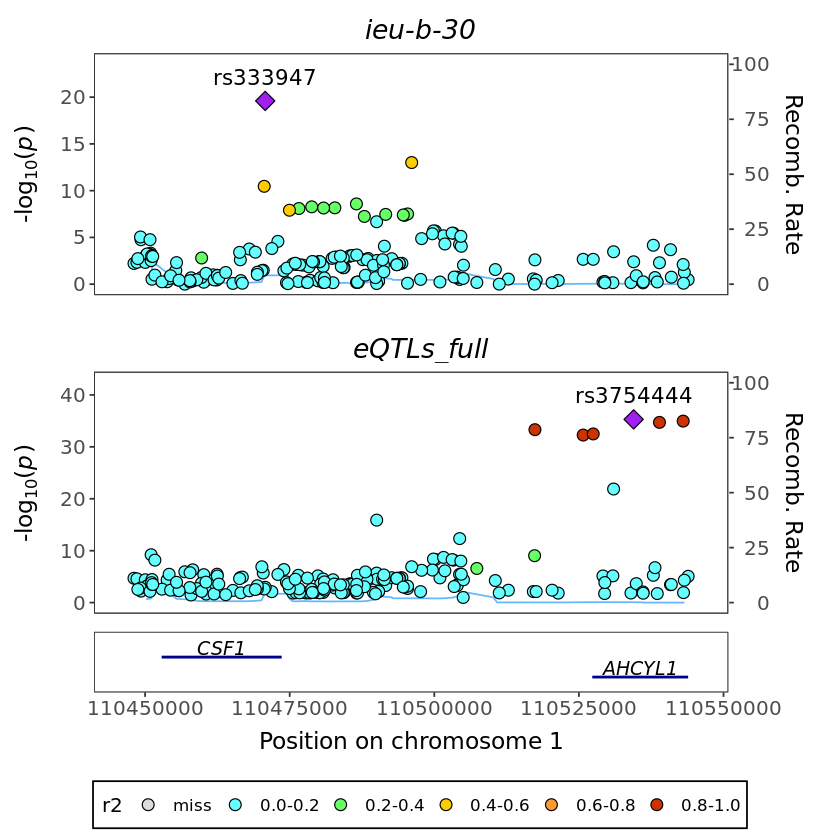

Extracting LD matrix for 439 variants

Please look at vignettes for options on running this locally if you need to run many instances of this command.

Warning message in ieugwasr::ld_matrix(markers[["marker"]], with_alleles = FALSE, :
“The following variants are not present in the LD reference panel
rs114583681
rs114793145
rs13119742
rs139818301
rs144485959
rs17006284
rs17351781
rs184386670
rs1876217
rs191620229
rs56352959
rs60192980
rs6820404
rs78324046”
Found 425 variants in LD reference panel



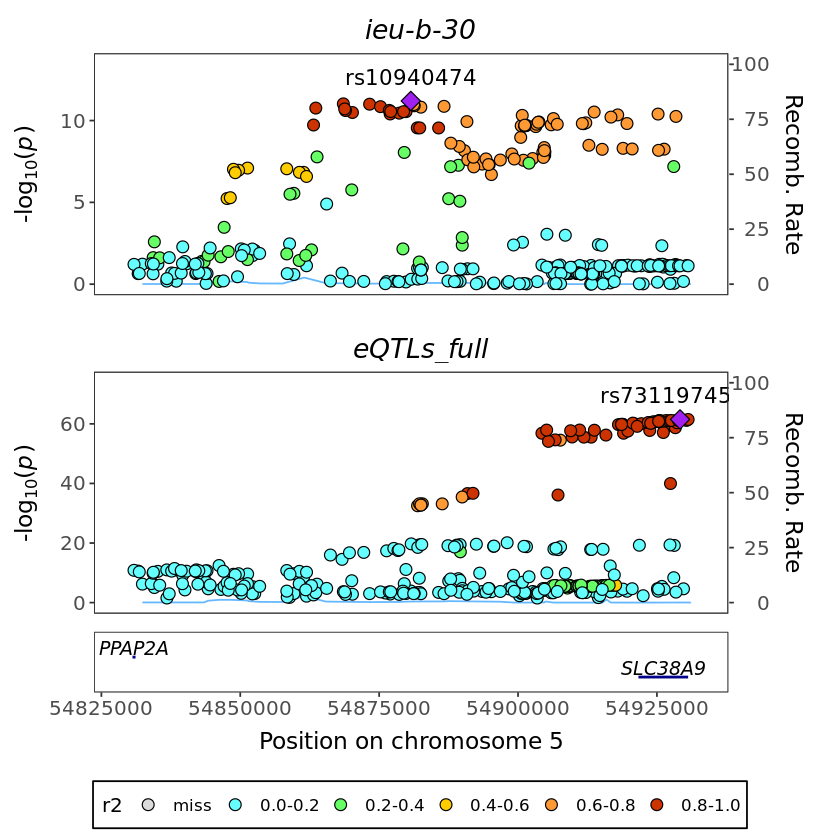

Extracting LD matrix for 309 variants

Please look at vignettes for options on running this locally if you need to run many instances of this command.

Warning message in ieugwasr::ld_matrix(markers[["marker"]], with_alleles = FALSE, :
“The following variants are not present in the LD reference panel
rs10077384
rs10491435
rs11567698
rs115835014
rs12654288
rs1389831
rs140126791
rs140399125
rs145513117
rs1494564
rs181341823
rs187815658
rs188503293
rs62351973
rs62353745
rs7718919
rs9292616”
Found 292 variants in LD reference panel



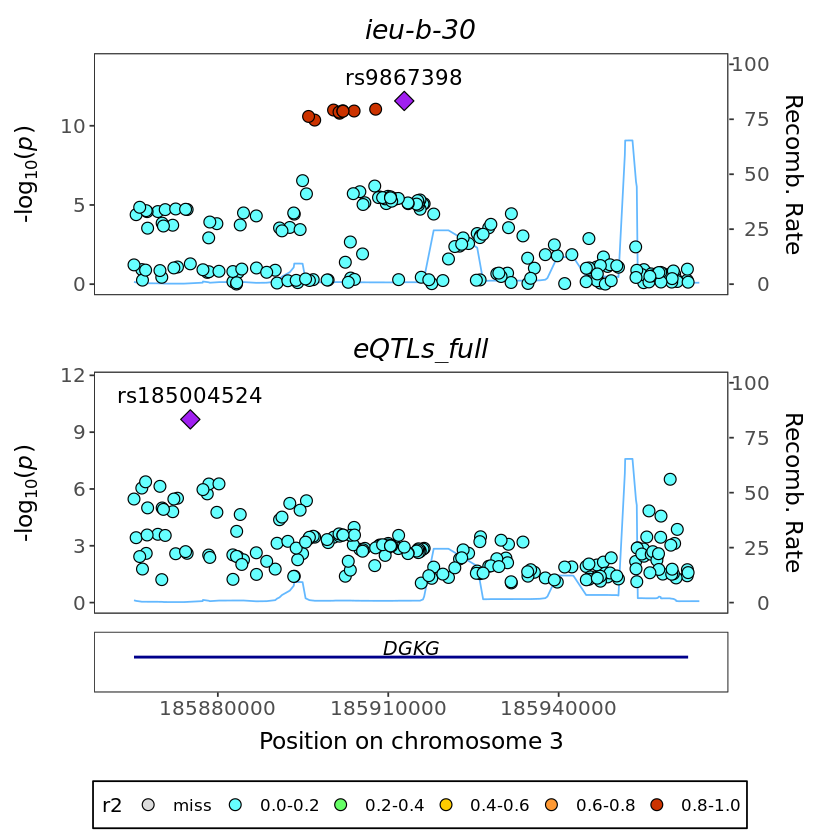

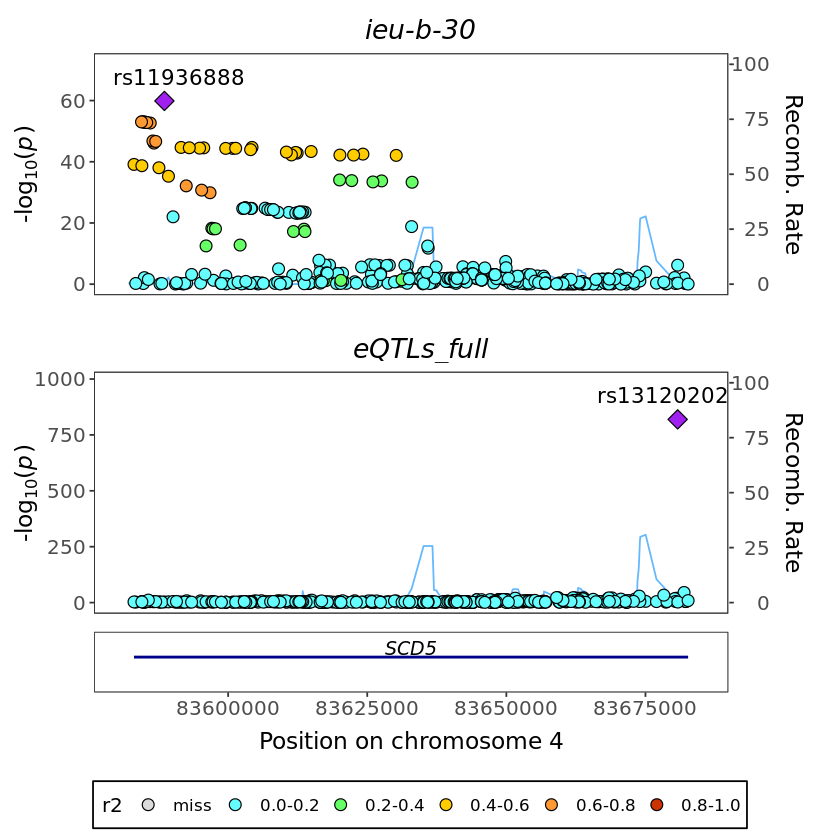

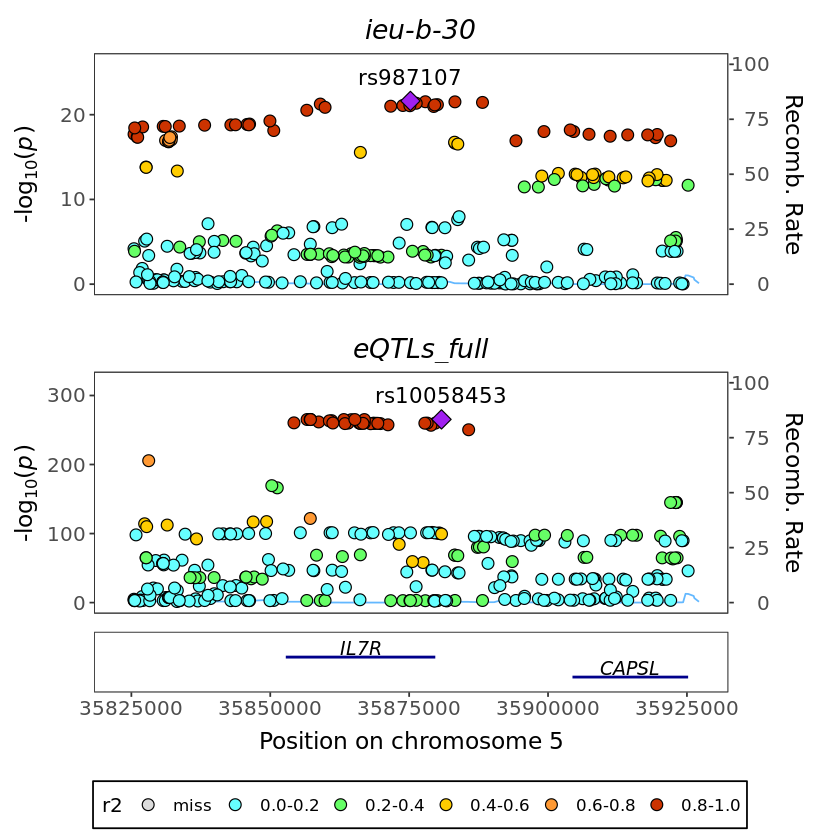

In [20]:
# get the highest priors from the H4 < 80% list to a dataframe named posteriors
posteriors <- read.table(file = "output_coloc/H4lt80.tsv", header = FALSE, sep = " ")

# manually name columns
colnames(posteriors) <- c("pval_rank", "chr", "lower", "upper", "PP.H1.abf", "PP.H2.abf", "PP.H3.abf", "PP.H4.abf")

# sort posteriors by the last column in descending order
posteriors <- posteriors[order(-posteriors$PP.H4.abf), ]

# only consider top 10 H4 posterior probabilities and identify gwas and eqtl rows they came from
top10H4 <- posteriors[1:10, ]
head(top10H4, n = 10L)


# manually set the gwas and eqtl file names by concatenating the values of the first 4 columns in top5H4
gwas_files <- paste0("gwas_hits/", top10H4$pval_rank, "_", top10H4$chr, "_", top10H4$lower, "_", top10H4$upper, "_gwas.tsv")
eqtl_files <- paste0("eqtl_hits/", top10H4$pval_rank, "_", top10H4$chr, "_", top10H4$lower, "_", top10H4$upper, "_eQTLs.tsv")

# loop over records and construct out object for plotting
for (i in seq_along(gwas_files)) {

    # loop over elements in gwas_file_list and eqtl_file_list at the same time
    gwas_file <- gwas_files[i]
    eqtl_file <- eqtl_files[i]

    gwas_data <- read.table(file = gwas_file, header = TRUE, sep = "\t")

    # working around formatting issues
    eqtl_data <- read.table(file = eqtl_file, header = FALSE, sep = "\t", fill = TRUE)
    # drop the last column in eqtl_data - not sure why there is an empty column read in from the file???
    eqtl_data <- eqtl_data[, -ncol(eqtl_data)]
    # rename the columns by first element
    colnames(eqtl_data) <- eqtl_data[1, ]
    # drop the first row
    eqtl_data <- eqtl_data[-1, ]
    # set column data types manually
    eqtl_data$pvalues <- as.numeric(eqtl_data$pvalues)
    eqtl_data$N <- as.integer(eqtl_data$N)
    eqtl_data$MAF <- as.numeric(eqtl_data$MAF)
    eqtl_data$beta <- as.numeric(eqtl_data$beta)
    eqtl_data$varbeta <- as.numeric(eqtl_data$varbeta)
    eqtl_data$type <- as.character(eqtl_data$type)
    eqtl_data$snp <- as.character(eqtl_data$snp)
    eqtl_data$z <- as.numeric(eqtl_data$z)
    eqtl_data$chr <- as.integer(eqtl_data$chr)
    eqtl_data$pos <- as.integer(eqtl_data$pos)
    eqtl_data$id <- as.character(eqtl_data$id)

    # subset gwas_data and eqtl_data for shared values of chr and pos, drop rows that don't exist in BOTH
    gwas_data <- gwas_data[gwas_data$chr %in% eqtl_data$chr & gwas_data$pos %in% eqtl_data$pos, ]
    eqtl_data <- eqtl_data[eqtl_data$chr %in% gwas_data$chr & eqtl_data$pos %in% gwas_data$pos, ]

    # create a list named out with two elements named dataset1 and dataset 2 and append gwas_data and eqtl_data
    out <- list(dataset1 = as.list(gwas_data), dataset2 = as.list(eqtl_data))

    # shorten the sublist named id to just 1 element
    out$dataset1$id <- out$dataset1$id[1]
    out$dataset2$id <- out$dataset2$id[1]
    # str(out)

    # plot the data
    temp <- coloc_to_gassocplot(out)
    # str(temp)
    gassocplot::stack_assoc_plot(temp$markers, temp$z, temp$corr, traits = temp$traits)
}
